# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# hide warnings all-time
import warnings
warnings.filterwarnings('ignore')


# import libraries
import pandas as pd
import numpy as np
import sqlalchemy
from sqlalchemy import create_engine
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download(['punkt','stopwords', 'wordnet', 'averaged_perceptron_tagger'])
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import FunctionTransformer
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
# load data from database
engine = create_engine('sqlite:///messages.db')
df = pd.read_sql_table("messages",con=engine)
X = df["message"]
Y = df.drop(columns=["message","id","original","genre"],axis=1)

In [3]:
X.head()

0    Weather update - a cold front from Cuba that c...
1              Is the Hurricane over or is it not over
2                      Looking for someone but no name
3    UN reports Leogane 80-90 destroyed. Only Hospi...
4    says: west side of Haiti, rest of the country ...
Name: message, dtype: object

In [4]:
Y.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
Y.loc[Y["related"]==2,"related"] = 1

In [4]:
Y[Y["related"]==2].shape

(0, 36)

### 2. Write a tokenization function to process your text data

In [4]:
def tokenize(text):
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # lemmatize andremove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [7]:
from sklearn.tree import DecisionTreeClassifier

In [5]:
pipeline =Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer()),
                ('clf', MultiOutputClassifier(DecisionTreeClassifier())) ])

In [11]:
X.head(10)

0    Weather update - a cold front from Cuba that c...
1              Is the Hurricane over or is it not over
2                      Looking for someone but no name
3    UN reports Leogane 80-90 destroyed. Only Hospi...
4    says: west side of Haiti, rest of the country ...
5               Information about the National Palace-
6                       Storm at sacred heart of jesus
7    Please, we need tents and water. We are in Sil...
8      I would like to receive the messages, thank you
9    I am in Croix-des-Bouquets. We have health iss...
Name: message, dtype: object

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.25, random_state=42)

In [29]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ion_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
           n_jobs=1))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [30]:
y_pred = pipeline.predict(X_test)

In [31]:
from sklearn.metrics import classification_report
# Print classification report on test data
print('\n',classification_report(y_test.values, y_pred, target_names=y_test.columns.values))
print("The F1 Micro Score is: {0:.2f}".format(f1_score(y_pred, y_test, average='micro')))
print("The F1 Macro Score (Unweighted average) is: {0:.2f}".format(f1_score(y_pred, y_test, average='macro')))


                         precision    recall  f1-score   support

               related       0.85      0.85      0.85      4977
               request       0.59      0.51      0.55      1133
                 offer       0.06      0.03      0.04        32
           aid_related       0.67      0.64      0.65      2720
          medical_help       0.37      0.31      0.34       522
      medical_products       0.41      0.40      0.40       311
     search_and_rescue       0.26      0.22      0.24       185
              security       0.13      0.09      0.11       133
              military       0.44      0.33      0.38       234
           child_alone       0.00      0.00      0.00         0
                 water       0.68      0.64      0.66       422
                  food       0.73      0.72      0.72       717
               shelter       0.61      0.63      0.62       575
              clothing       0.49      0.45      0.47        91
                 money       0.36    

In [32]:
for column in y_test.columns:
    print("---------------------" + column + "--------------------------------------------- ")
    print(classification_report(y_test.iloc[:,y_test.columns.get_loc(column)],y_pred[:,y_test.columns.get_loc(column)]))

---------------------related--------------------------------------------- 
             precision    recall  f1-score   support

          0       0.52      0.52      0.52      1568
          1       0.85      0.85      0.85      4977

avg / total       0.77      0.77      0.77      6545

---------------------request--------------------------------------------- 
             precision    recall  f1-score   support

          0       0.90      0.93      0.91      5412
          1       0.59      0.51      0.55      1133

avg / total       0.85      0.85      0.85      6545

---------------------offer--------------------------------------------- 
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6513
          1       0.06      0.03      0.04        32

avg / total       0.99      0.99      0.99      6545

---------------------aid_related--------------------------------------------- 
             precision    recall  f1-score   support


### 6. Improve your model
Use grid search to find better parameters. 

In [7]:
def multiOutputF1_beta_score(y_true,y_pred,beta=2):
    """
    MultiOutput F1_beta_score
    
    This is a custom metric which is created with f1_beta. 
    
    It is used in gridsearch for scoring.
    
    Since recall is very important to not miss important help issues, we choice beta as 2. 
    Check details for beta: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html
 
    """
    critical_types = ["search_and_rescue","missing_people","death","medical_products","medical_help","food","water"]
    score_sum = 0
    for column in range(0,y_true.shape[1]):
        score = fbeta_score(y_true.loc[:,y_true.columns[column]],y_pred[:,column], beta, average='binary')
        if y_true.columns[column] in set(critical_types):
            score = score * 4
        score_sum += score
    avg_f1_beta = score_sum / ( y_true.shape[1] + (len(critical_types) * 4) - 7 )
    return  avg_f1_beta

In [17]:
from sklearn.grid_search import GridSearchCV

params =  {'clf__estimator__max_depth':[20,30,50,100],
          "clf__estimator__min_samples_leaf": [10,30,50,100]
          }

grid_search = GridSearchCV(pipeline, params, n_jobs=-1,verbose=1 )
grid_search.fit(X_train, y_train)
print('Best score: %0.3f' % grid_search.best_score_)
print ('Best parameters set:')
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))

predictions = grid_search.predict(X_test)

# Print classification report on training data
print('\n',classification_report(y_test.values, predictions, target_names=y_test.columns.values))

## get the result score
print("The F1 Micro Score is: {0:.2f}".format(f1_score(predictions, y_test, average='micro')))
print("The F1 Macro Score (Unweighted average) is: {0:.2f}".format(f1_score(predictions, y_test, average='macro')))
print("The F1_Beta Score with Beta=2 is:  {0:.2f}".format(multiOutputF1_beta_score(y_test,predictions,beta=2)))

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 27.1min finished


Best score: 0.250
Best parameters set:
	clf__estimator__max_depth: 100
	clf__estimator__min_samples_leaf: 30

                         precision    recall  f1-score   support

               related       0.83      0.92      0.87      4977
               request       0.74      0.46      0.57      1133
                 offer       0.00      0.00      0.00        32
           aid_related       0.70      0.66      0.68      2720
          medical_help       0.55      0.26      0.35       522
      medical_products       0.67      0.33      0.44       311
     search_and_rescue       0.67      0.18      0.29       185
              security       0.00      0.00      0.00       133
              military       0.52      0.29      0.37       234
           child_alone       0.00      0.00      0.00         0
                 water       0.74      0.62      0.68       422
                  food       0.77      0.76      0.76       717
               shelter       0.76      0.60      0.67   

### Try a custom scorer 

In [8]:
from sklearn.metrics import make_scorer
scorer = make_scorer(multiOutputF1_beta_score,beta=2)

In [9]:
### Test with custom scoring

params =  {'clf__estimator__max_depth':[20,30,50,100],
          "clf__estimator__min_samples_leaf": [10,30,50,100]
           }
grid_search = GridSearchCV(pipeline, params, n_jobs=-1,verbose=1, scoring=scorer)
grid_search.fit(X_train, y_train)
print('Best score: %0.3f' % grid_search.best_score_)
print ('Best parameters set:')

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))

predictions = grid_search.predict(X_test)

# Print classification report on training data
print('\n',classification_report(y_test.values, predictions, target_names=y_test.columns.values))

## get the result score
print("The F1 Micro Score is: {0:.2f}".format(f1_score(predictions, y_test, average='micro')))
print("The F1 Macro Score (Unweighted average) is: {0:.2f}".format(f1_score(predictions, y_test, average='macro')))
print("The F1_Beta Score with Beta=2 is:  {0:.2f}".format(multiOutputF1_beta_score(y_test,predictions,beta=2)))

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 32.2min finished


Best score: 0.381
Best parameters set:
	clf__estimator__max_depth: 20
	clf__estimator__min_samples_leaf: 10

                         precision    recall  f1-score   support

               related       0.79      0.96      0.87      4977
               request       0.71      0.46      0.56      1133
                 offer       0.00      0.00      0.00        32
           aid_related       0.76      0.52      0.61      2720
          medical_help       0.53      0.27      0.36       522
      medical_products       0.62      0.34      0.44       311
     search_and_rescue       0.56      0.12      0.20       185
              security       0.29      0.05      0.08       133
              military       0.52      0.37      0.43       234
           child_alone       0.00      0.00      0.00         0
                 water       0.73      0.61      0.67       422
                  food       0.78      0.79      0.79       717
               shelter       0.72      0.57      0.63    

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [20]:
for column in y_test.columns:
    print("---------------------" + column + "--------------------------------------------- ")
    print(classification_report(y_test.iloc[:,y_test.columns.get_loc(column)],predictions[:,y_test.columns.get_loc(column)]))

---------------------related--------------------------------------------- 
             precision    recall  f1-score   support

          0       0.62      0.25      0.35      1568
          1       0.80      0.95      0.87      4977

avg / total       0.76      0.78      0.75      6545

---------------------request--------------------------------------------- 
             precision    recall  f1-score   support

          0       0.90      0.96      0.92      5412
          1       0.69      0.47      0.56      1133

avg / total       0.86      0.87      0.86      6545

---------------------offer--------------------------------------------- 
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6513
          1       0.00      0.00      0.00        32

avg / total       0.99      1.00      0.99      6545

---------------------aid_related--------------------------------------------- 
             precision    recall  f1-score   support


In [21]:
## get the result score
print("The F1 Micro Score is: {0:.2f}".format(f1_score(predictions, y_test, average='micro')))
print("The F1 Macro Score (Unweighted average) is: {0:.2f}".format(f1_score(predictions, y_test, average='macro')))
print("The F1_Beta Score with Beta=2 is:  {0:.2f}".format(multiOutputF1_beta_score(y_test,predictions,beta=2)))

The F1 Micro Score is: 0.65
The F1 Macro Score (Unweighted average) is: 0.39
The F1_Beta Score with Beta=2 is:  0.38


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### RANDOM FOREST CLASSIFIER

In [18]:
## create a new pipeline
pipeline =Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer()),
                ('clf', MultiOutputClassifier(RandomForestClassifier()))])
## train estimator with pipeline
pipeline.fit(X_train, y_train)

## Gridsearch best parameters with GridSearchCV

# A parameter grid for XGBoost

params = {
        'clf__estimator__min_samples_split': (10,30,50,100),
        'clf__estimator__max_depth': (30,50,100)
         }

grid_search = GridSearchCV(pipeline, params, n_jobs=-1,verbose=1,scoring=scorer)
grid_search.fit(X_train, y_train)
print('Best score: %0.3f' % grid_search.best_score_)
print ('Best parameters set:')
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))

predictions = grid_search.predict(X_test)

# Print classification report on training data
print('\n',classification_report(y_test.values, predictions, target_names=y_test.columns.values))

## get the result score
print("The F1 Micro Score is: {0:.2f}".format(f1_score(predictions, y_test, average='micro')))
print("The F1 Macro Score (Unweighted average) is: {0:.2f}".format(f1_score(predictions, y_test, average='macro')))
print("The F1_Beta Score with Beta=2 is:  {0:.2f}".format(multiOutputF1_beta_score(y_test,predictions,beta=2)))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 14.1min finished


Best score: 0.169
Best parameters set:
	clf__estimator__max_depth: 100
	clf__estimator__min_samples_split: 10

                         precision    recall  f1-score   support

               related       0.80      0.98      0.88      4977
               request       0.83      0.38      0.52      1133
                 offer       0.00      0.00      0.00        32
           aid_related       0.75      0.61      0.67      2720
          medical_help       0.72      0.06      0.10       522
      medical_products       0.67      0.09      0.16       311
     search_and_rescue       1.00      0.02      0.04       185
              security       0.00      0.00      0.00       133
              military       0.73      0.07      0.13       234
           child_alone       0.00      0.00      0.00         0
                 water       0.89      0.18      0.30       422
                  food       0.83      0.30      0.44       717
               shelter       0.77      0.21      0.33  

In [19]:
for column in y_test.columns:
    print("---------------------" + column + "--------------------------------------------- ")
    print(classification_report(y_test.iloc[:,y_test.columns.get_loc(column)],predictions[:,y_test.columns.get_loc(column)]))

---------------------related--------------------------------------------- 
             precision    recall  f1-score   support

          0       0.76      0.22      0.34      1568
          1       0.80      0.98      0.88      4977

avg / total       0.79      0.80      0.75      6545

---------------------request--------------------------------------------- 
             precision    recall  f1-score   support

          0       0.88      0.98      0.93      5412
          1       0.83      0.38      0.52      1133

avg / total       0.87      0.88      0.86      6545

---------------------offer--------------------------------------------- 
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6513
          1       0.00      0.00      0.00        32

avg / total       0.99      1.00      0.99      6545

---------------------aid_related--------------------------------------------- 
             precision    recall  f1-score   support


### 9. Export your model as a pickle file

In [ ]:
## best model is resulted by decision tree algorithm & default scoring

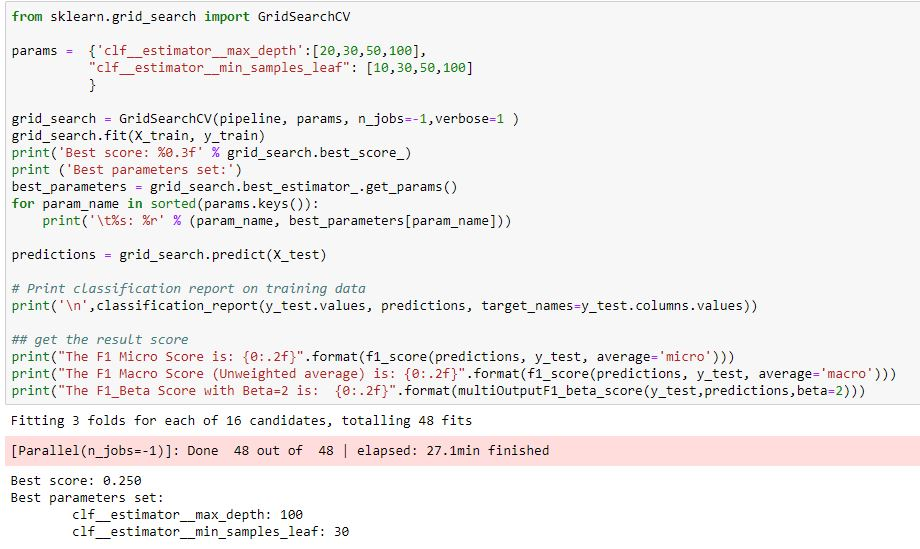

In [10]:
from sklearn.externals import joblib
joblib.dump(grid_search.best_estimator_, 'classifier.pkl')

['classifier.pkl']

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.